**Carupah - CarupAI - Natural Language Processing** 

In [183]:
#Import Libraries and Packages Needed
import tensorflow as tf
import numpy as np
import nltk
import json
import pickle
import random
import requests
import matplotlib.pyplot as plt

#from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.losses import categorical_crossentropy
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation
from nltk.stem import WordNetLemmatizer
from keras.callbacks import EarlyStopping

nltk.download('punkt') #Tokenizer
nltk.download('wordnet') #Lemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

**Get Dataset from Gdrive**

In [184]:
#Where file JSON is Stored
url = 'https://drive.google.com/uc?id=1-MClkBk3glO-MBTa3xQUD9QqVGIQqveo'
response = requests.get(url)
chatbot_json = response.content

In [185]:
chatbot_dataset = json.loads(chatbot_json) #Read file

In [186]:
print(json.dumps(chatbot_dataset, indent=5)) #See data

{
     "intents": [
          {
               "tag": "greeting",
               "patterns": [
                    "Hi",
                    "Hello",
                    "Hallo",
                    "Hey",
                    "Mau tanya",
                    "Hai, Welcome",
                    "Ingin bertanya"
               ],
               "responses": [
                    "Hello, Kamu mau bertanya?",
                    "Hai, Selamat datang. Ada yang mau kamu tanyakan?",
                    "Hi, kamu punya pertanyaan apa?",
                    "Ada yang bisa CarupAI bantu?"
               ],
               "context": [
                    ""
               ]
          },
          {
               "tag": "goodbye",
               "patterns": [
                    "Bye",
                    "Sampai jumpa lagi",
                    "Okay, bye",
                    "Senang berbicara dengan CarupAI, bye"
               ],
               "responses": [
                    "Sampai jumpa

**Tokenization and Lemmatization**

In [187]:
#Variables
words=[]
classes=[]
documents=[]
ignore_sign=["!","?"]

In [188]:
for intent in chatbot_dataset['intents']:
  for pattern in intent['patterns']:

    #Tokenization
    word = nltk.word_tokenize(pattern)
    words.extend(word)
    documents.append((word, intent['tag'])) #each word to document, related with tag

    #add tag to classes 
    if intent['tag'] not in classes:
       classes.append(intent['tag'])

In [189]:
#Lemmatization
lemmatizer = WordNetLemmatizer()
words = [lemmatizer.lemmatize(word.lower()) for word in words if word not in ignore_sign]

#Delete duplicates and sort
words = sorted(list(set(words)))
classes = sorted(list(set(classes)))

print (len(words), "lemmatized words", words) #uniqe words
print (len(classes), "classes", classes) #tags
print (len(documents), "documents") 

108 lemmatized words [',', 'ada', 'adalah', 'air', 'aja', 'aluminium', 'anorganik', 'apa', 'bagaimana', 'bagamana', 'bantuan', 'berbicara', 'berikan', 'bertanya', 'buang', 'bye', 'cara', 'carupah', 'carupai', 'contoh', 'dampak', 'dan', 'dapat', 'daur', 'dengan', 'detergen', 'disposal', 'dong', 'efek', 'elektronik', 'hai', 'hallo', 'hasil', 'hdpe', 'hello', 'hey', 'hi', 'ingin', 'itu', 'jelasin', 'jelaskan', 'jenis', 'jenis-jenis', 'jumpa', 'kaca', 'kamu', 'kardus', 'kasih', 'kategori', 'kenapa', 'ketegori', 'keunggulan', 'kompos', 'lagi', 'lakukan', 'limbah', 'manfaat', 'mau', 'memanfaatkan', 'membantu', 'membantuku', 'membuang', 'membuat', 'memisahkan', 'mengatasi', 'mengelola', 'menggunakan', 'okay', 'organik', 'penanganan', 'pengelolaan', 'pengertian', 'penggunaan', 'pengomposaan', 'pengunaan', 'penjelasan', 'penting', 'pentingnya', 'plastik', 'produk', 'recycle', 'reduce', 'reuse', 'saja', 'sampah', 'sampai', 'sangat', 'sebut', 'sebutkan', 'senang', 'siapa', 'sih', 'styrofoam', 'su

**Save Variables and Create Training data**

In [190]:
#Saved python object to binner file
pickle.dump(words, open('data_words.pkl','wb'))
pickle.dump(classes, open('data_classes.pkl','wb'))

In [191]:
#Create Training Data

training = [] #save training data
output_empty = [0] * len(classes) #store the output labels corresponding to each pattern.

# Bag of Words
for document in documents:
    bag = [] #save bag of words
    pattern_words = document[0] #Get words from pattern
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words] #lemmatize each word

    #If the current word is in the sentence pattern
    for word in words:
        if word in pattern_words:
            bag.append(1) #it adds the number 1 to the bag
        else:
            bag.append(0) #Otherwise, it adds a 0.

    output_row = list(output_empty) #list is initially initialized with all elements=0
    output_row[classes.index(document[1])] = 1 #If corresponds to the class index will be set to 1, while the other elements remain 0.
    training.append([bag, output_row]) #add to training list as training data

random.shuffle(training) #Randomize the order of training data.
training = np.array(training, dtype=object) #Convert the training list into a NumPy array.
train_x = list(training[:,0]) #contains sentence patterns from the training data.
train_y = list(training[:,1]) #contains output labels that match the sentence patterns from the training data.

**Create Neural Network Model for Natural Language Processing**

In [192]:
# Create model 
model = Sequential([
    Dense(128, input_shape=(len(train_x[0]),), activation='relu'), #First Layer 
    Dropout(0.5),
    Dense(64, activation='relu'), #Second Layer
    Dropout(0.5),
    Dense(len(train_y[0]), activation='softmax') #Output Layer
])

sgd = SGD(learning_rate=0.01, 
          decay=1e-6, 
          momentum=0.9, 
          nesterov=True
          )

model.compile(loss='categorical_crossentropy', 
              optimizer=sgd, 
              metrics=['accuracy']
              )

'''
#Compile model
model.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.01), 
    metrics=['accuracy']
    )
'''


"\n#Compile model\nmodel.compile(\n    loss='categorical_crossentropy', \n    optimizer=Adam(learning_rate=0.01), \n    metrics=['accuracy']\n    )\n"

**Model Summary**

In [193]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 128)               13952     
                                                                 
 dropout_18 (Dropout)        (None, 128)               0         
                                                                 
 dense_28 (Dense)            (None, 64)                8256      
                                                                 
 dropout_19 (Dropout)        (None, 64)                0         
                                                                 
 dense_29 (Dense)            (None, 44)                2860      
                                                                 
Total params: 25,068
Trainable params: 25,068
Non-trainable params: 0
_________________________________________________________________


**Train Model**

In [170]:
#early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [194]:
#Training
history = model.fit(np.array(train_x), 
                    np.array(train_y), 
                    epochs=200, 
                    batch_size=5, 
                    verbose=1
                    #callbacks=[early_stopping]
                    )

Epoch 1/200
29/49 [================>.............] - ETA: 0s - loss: 3.7929 - accuracy: 0.0138     

49/49 [==============================] - 1s 2ms/step - loss: 3.8000 - accuracy: 0.0124
Epoch 2/200
30/49 [=================>............] - ETA: 0s - loss: 3.7617 - accuracy: 0.0200    

49/49 [==============================] - 0s 2ms/step - loss: 3.7380 - accuracy: 0.0456
Epoch 3/200
30/49 [=================>............] - ETA: 0s - loss: 3.6796 - accuracy: 0.0733

49/49 [==============================] - 0s 2ms/step - loss: 3.6898 - accuracy: 0.0705
Epoch 4/200
31/49 [=================>............] - ETA: 0s - loss: 3.6095 - accuracy: 0.1032    

49/49 [==============================] - 0s 2ms/step - loss: 3.6051 - accuracy: 0.0871
Epoch 5/200
30/49 [=================>............] - ETA: 0s - loss: 3.4050 - accuracy: 0.1467

49/49 [==============================] - 0s 2ms/step - loss: 3.4042 - accuracy: 0.1411
Epoch 6/200
30/49 [=================>............] - ETA: 0s - loss: 3.2579 - accuracy: 0.1867

49/49 [==============================] - 0s 2ms/step - loss: 3.2728 - accuracy: 0.1660
Epoch 7/200
30/49 [=================>............] - ETA: 0s - loss: 3.0919 - accuracy: 0.1933

49/49 [==============================] - 0s 2ms/step - loss: 3.0277 - accuracy: 0.1826
Epoch 8/200
28/49 [================>.............] - ETA: 0s - loss: 2.6480 - accuracy: 0.3071

49/49 [==============================] - 0s 2ms/step - loss: 2.7542 - accuracy: 0.2573
Epoch 9/200
29/49 [================>.............] - ETA: 0s - loss: 2.4926 - accuracy: 0.3241

49/49 [==============================] - 0s 2ms/step - loss: 2.4175 - accuracy: 0.3278
Epoch 10/200
30/49 [=================>............] - ETA: 0s - loss: 2.1997 - accuracy: 0.3800

49/49 [==============================] - 0s 2ms/step - loss: 2.1884 - accuracy: 0.3734
Epoch 11/200
31/49 [=================>............] - ETA: 0s - loss: 1.9954 - accuracy: 0.4065

49/49 [==============================] - 0s 2ms/step - loss: 2.0366 - accuracy: 0.4066
Epoch 12/200
32/49 [==================>...........] - ETA: 0s - loss: 1.8787 - accuracy: 0.4688

49/49 [==============================] - 0s 2ms/step - loss: 1.8773 - accuracy: 0.4440
Epoch 13/200
29/49 [================>.............] - ETA: 0s - loss: 1.5461 - accuracy: 0.5517

49/49 [==============================] - 0s 2ms/step - loss: 1.6457 - accuracy: 0.5062
Epoch 14/200
28/49 [================>.............] - ETA: 0s - loss: 1.5421 - accuracy: 0.5429

49/49 [==============================] - 0s 2ms/step - loss: 1.5445 - accuracy: 0.5270
Epoch 15/200
48/49 [============================>.] - ETA: 0s - loss: 1.3680 - accuracy: 0.5917

49/49 [==============================] - 0s 2ms/step - loss: 1.3626 - accuracy: 0.5934
Epoch 16/200
26/49 [==============>...............] - ETA: 0s - loss: 1.2714 - accuracy: 0.6000

49/49 [==============================] - 0s 2ms/step - loss: 1.3256 - accuracy: 0.5809
Epoch 17/200
29/49 [================>.............] - ETA: 0s - loss: 1.2200 - accuracy: 0.6276

49/49 [==============================] - 0s 2ms/step - loss: 1.1361 - accuracy: 0.6390
Epoch 18/200
30/49 [=================>............] - ETA: 0s - loss: 1.1442 - accuracy: 0.6600

49/49 [==============================] - 0s 2ms/step - loss: 1.0618 - accuracy: 0.6680
Epoch 19/200
24/49 [=============>................] - ETA: 0s - loss: 1.2397 - accuracy: 0.6500

49/49 [==============================] - 0s 2ms/step - loss: 1.1867 - accuracy: 0.6224
Epoch 20/200
23/49 [=============>................] - ETA: 0s - loss: 1.0507 - accuracy: 0.6870

49/49 [==============================] - 0s 2ms/step - loss: 1.0526 - accuracy: 0.6763
Epoch 21/200
25/49 [==============>...............] - ETA: 0s - loss: 0.8981 - accuracy: 0.7120

49/49 [==============================] - 0s 2ms/step - loss: 0.8840 - accuracy: 0.7095
Epoch 22/200
29/49 [================>.............] - ETA: 0s - loss: 1.0014 - accuracy: 0.6966

49/49 [==============================] - 0s 2ms/step - loss: 0.9960 - accuracy: 0.6971
Epoch 23/200
29/49 [================>.............] - ETA: 0s - loss: 0.9043 - accuracy: 0.7103

49/49 [==============================] - 0s 2ms/step - loss: 0.9255 - accuracy: 0.7054
Epoch 24/200
31/49 [=================>............] - ETA: 0s - loss: 0.9175 - accuracy: 0.6839

49/49 [==============================] - 0s 2ms/step - loss: 0.8556 - accuracy: 0.7261
Epoch 25/200
28/49 [================>.............] - ETA: 0s - loss: 0.8355 - accuracy: 0.7357

49/49 [==============================] - 0s 2ms/step - loss: 0.8230 - accuracy: 0.7178
Epoch 26/200
30/49 [=================>............] - ETA: 0s - loss: 0.9199 - accuracy: 0.7000

49/49 [==============================] - 0s 2ms/step - loss: 0.8393 - accuracy: 0.7261
Epoch 27/200
28/49 [================>.............] - ETA: 0s - loss: 0.6916 - accuracy: 0.7357

49/49 [==============================] - 0s 2ms/step - loss: 0.6785 - accuracy: 0.7469
Epoch 28/200
30/49 [=================>............] - ETA: 0s - loss: 0.6956 - accuracy: 0.7600

49/49 [==============================] - 0s 2ms/step - loss: 0.6629 - accuracy: 0.7718
Epoch 29/200
31/49 [=================>............] - ETA: 0s - loss: 0.6878 - accuracy: 0.7613

49/49 [==============================] - 0s 2ms/step - loss: 0.6935 - accuracy: 0.7676
Epoch 30/200
31/49 [=================>............] - ETA: 0s - loss: 0.6693 - accuracy: 0.7613

49/49 [==============================] - 0s 2ms/step - loss: 0.6472 - accuracy: 0.7593
Epoch 31/200
28/49 [================>.............] - ETA: 0s - loss: 0.6681 - accuracy: 0.7429

49/49 [==============================] - 0s 2ms/step - loss: 0.6315 - accuracy: 0.7759
Epoch 32/200
27/49 [===============>..............] - ETA: 0s - loss: 0.6156 - accuracy: 0.8000

49/49 [==============================] - 0s 2ms/step - loss: 0.6116 - accuracy: 0.8174
Epoch 33/200
28/49 [================>.............] - ETA: 0s - loss: 0.6293 - accuracy: 0.7786

49/49 [==============================] - 0s 2ms/step - loss: 0.6430 - accuracy: 0.7635
Epoch 34/200
26/49 [==============>...............] - ETA: 0s - loss: 0.6253 - accuracy: 0.8231

49/49 [==============================] - 0s 2ms/step - loss: 0.6268 - accuracy: 0.8091
Epoch 35/200
27/49 [===============>..............] - ETA: 0s - loss: 0.7261 - accuracy: 0.7481

49/49 [==============================] - 0s 2ms/step - loss: 0.6257 - accuracy: 0.8050
Epoch 36/200
26/49 [==============>...............] - ETA: 0s - loss: 0.8258 - accuracy: 0.7538

49/49 [==============================] - 0s 2ms/step - loss: 0.6902 - accuracy: 0.7801
Epoch 37/200
23/49 [=============>................] - ETA: 0s - loss: 0.5280 - accuracy: 0.8348

49/49 [==============================] - 0s 2ms/step - loss: 0.5276 - accuracy: 0.8340
Epoch 38/200
23/49 [=============>................] - ETA: 0s - loss: 0.5372 - accuracy: 0.8087

49/49 [==============================] - 0s 2ms/step - loss: 0.5392 - accuracy: 0.8257
Epoch 39/200
26/49 [==============>...............] - ETA: 0s - loss: 0.6452 - accuracy: 0.7923

49/49 [==============================] - 0s 2ms/step - loss: 0.6420 - accuracy: 0.7842
Epoch 40/200
29/49 [================>.............] - ETA: 0s - loss: 0.6535 - accuracy: 0.7448

49/49 [==============================] - 0s 2ms/step - loss: 0.6254 - accuracy: 0.7759
Epoch 41/200
49/49 [==============================] - ETA: 0s - loss: 0.4839 - accuracy: 0.8423

49/49 [==============================] - 0s 2ms/step - loss: 0.4839 - accuracy: 0.8423
Epoch 42/200
38/49 [======================>.......] - ETA: 0s - loss: 0.4686 - accuracy: 0.8316

49/49 [==============================] - 0s 3ms/step - loss: 0.4886 - accuracy: 0.8340
Epoch 43/200
37/49 [=====================>........] - ETA: 0s - loss: 0.2926 - accuracy: 0.9081

49/49 [==============================] - 0s 3ms/step - loss: 0.3109 - accuracy: 0.8963
Epoch 44/200
39/49 [======================>.......] - ETA: 0s - loss: 0.4429 - accuracy: 0.8667

49/49 [==============================] - 0s 3ms/step - loss: 0.4549 - accuracy: 0.8631
Epoch 45/200
38/49 [======================>.......] - ETA: 0s - loss: 0.3636 - accuracy: 0.8789

49/49 [==============================] - 0s 3ms/step - loss: 0.3825 - accuracy: 0.8672
Epoch 46/200
40/49 [=======================>......] - ETA: 0s - loss: 0.5010 - accuracy: 0.8400

49/49 [==============================] - 0s 3ms/step - loss: 0.4838 - accuracy: 0.8548
Epoch 47/200
43/49 [=========================>....] - ETA: 0s - loss: 0.4306 - accuracy: 0.8558

49/49 [==============================] - 0s 3ms/step - loss: 0.4506 - accuracy: 0.8548
Epoch 48/200
42/49 [========================>.....] - ETA: 0s - loss: 0.3906 - accuracy: 0.8857

49/49 [==============================] - 0s 3ms/step - loss: 0.3853 - accuracy: 0.8921
Epoch 49/200
36/49 [=====================>........] - ETA: 0s - loss: 0.4091 - accuracy: 0.8556

49/49 [==============================] - 0s 3ms/step - loss: 0.4530 - accuracy: 0.8382
Epoch 50/200
41/49 [========================>.....] - ETA: 0s - loss: 0.4572 - accuracy: 0.8634

49/49 [==============================] - 0s 3ms/step - loss: 0.4723 - accuracy: 0.8548
Epoch 51/200
38/49 [======================>.......] - ETA: 0s - loss: 0.4928 - accuracy: 0.8684

49/49 [==============================] - 0s 3ms/step - loss: 0.4348 - accuracy: 0.8797
Epoch 52/200
34/49 [===================>..........] - ETA: 0s - loss: 0.3500 - accuracy: 0.9000

49/49 [==============================] - 0s 3ms/step - loss: 0.3653 - accuracy: 0.8963
Epoch 53/200
38/49 [======================>.......] - ETA: 0s - loss: 0.3958 - accuracy: 0.8474

49/49 [==============================] - 0s 3ms/step - loss: 0.3998 - accuracy: 0.8589
Epoch 54/200
38/49 [======================>.......] - ETA: 0s - loss: 0.4136 - accuracy: 0.8526

49/49 [==============================] - 0s 3ms/step - loss: 0.3773 - accuracy: 0.8631
Epoch 55/200
41/49 [========================>.....] - ETA: 0s - loss: 0.5540 - accuracy: 0.8098

49/49 [==============================] - 0s 3ms/step - loss: 0.5078 - accuracy: 0.8216
Epoch 56/200
41/49 [========================>.....] - ETA: 0s - loss: 0.4632 - accuracy: 0.8341

49/49 [==============================] - 0s 3ms/step - loss: 0.4298 - accuracy: 0.8548
Epoch 57/200
42/49 [========================>.....] - ETA: 0s - loss: 0.3742 - accuracy: 0.8762

49/49 [==============================] - 0s 3ms/step - loss: 0.3762 - accuracy: 0.8838
Epoch 58/200
41/49 [========================>.....] - ETA: 0s - loss: 0.3122 - accuracy: 0.8976

49/49 [==============================] - 0s 3ms/step - loss: 0.3342 - accuracy: 0.8838
Epoch 59/200
35/49 [====================>.........] - ETA: 0s - loss: 0.5096 - accuracy: 0.8400

49/49 [==============================] - 0s 3ms/step - loss: 0.4866 - accuracy: 0.8423
Epoch 60/200
36/49 [=====================>........] - ETA: 0s - loss: 0.4082 - accuracy: 0.8556

49/49 [==============================] - 0s 3ms/step - loss: 0.4237 - accuracy: 0.8548
Epoch 61/200
42/49 [========================>.....] - ETA: 0s - loss: 0.4209 - accuracy: 0.8952

49/49 [==============================] - 0s 3ms/step - loss: 0.3797 - accuracy: 0.9087
Epoch 62/200
38/49 [======================>.......] - ETA: 0s - loss: 0.2786 - accuracy: 0.9263

49/49 [==============================] - 0s 3ms/step - loss: 0.3000 - accuracy: 0.9170
Epoch 63/200
42/49 [========================>.....] - ETA: 0s - loss: 0.4284 - accuracy: 0.8238

49/49 [==============================] - 0s 3ms/step - loss: 0.4523 - accuracy: 0.8174
Epoch 64/200
25/49 [==============>...............] - ETA: 0s - loss: 0.2277 - accuracy: 0.9440

49/49 [==============================] - 0s 2ms/step - loss: 0.2776 - accuracy: 0.9129
Epoch 65/200
28/49 [================>.............] - ETA: 0s - loss: 0.2942 - accuracy: 0.9071

49/49 [==============================] - 0s 2ms/step - loss: 0.3395 - accuracy: 0.8880
Epoch 66/200
27/49 [===============>..............] - ETA: 0s - loss: 0.3766 - accuracy: 0.8519

49/49 [==============================] - 0s 2ms/step - loss: 0.3945 - accuracy: 0.8506
Epoch 67/200
30/49 [=================>............] - ETA: 0s - loss: 0.2339 - accuracy: 0.9133

49/49 [==============================] - 0s 2ms/step - loss: 0.2313 - accuracy: 0.9170
Epoch 68/200
28/49 [================>.............] - ETA: 0s - loss: 0.3566 - accuracy: 0.8786

49/49 [==============================] - 0s 2ms/step - loss: 0.3385 - accuracy: 0.8880
Epoch 69/200
31/49 [=================>............] - ETA: 0s - loss: 0.3389 - accuracy: 0.9032

49/49 [==============================] - 0s 2ms/step - loss: 0.3459 - accuracy: 0.8921
Epoch 70/200
29/49 [================>.............] - ETA: 0s - loss: 0.3293 - accuracy: 0.8897

49/49 [==============================] - 0s 2ms/step - loss: 0.3679 - accuracy: 0.8880
Epoch 71/200
30/49 [=================>............] - ETA: 0s - loss: 0.5360 - accuracy: 0.8267

49/49 [==============================] - 0s 2ms/step - loss: 0.5361 - accuracy: 0.8257
Epoch 72/200
30/49 [=================>............] - ETA: 0s - loss: 0.3237 - accuracy: 0.8600

49/49 [==============================] - 0s 2ms/step - loss: 0.3532 - accuracy: 0.8672
Epoch 73/200
30/49 [=================>............] - ETA: 0s - loss: 0.4228 - accuracy: 0.8667

49/49 [==============================] - 0s 2ms/step - loss: 0.4455 - accuracy: 0.8589
Epoch 74/200
29/49 [================>.............] - ETA: 0s - loss: 0.3657 - accuracy: 0.8897

49/49 [==============================] - 0s 2ms/step - loss: 0.3458 - accuracy: 0.8963
Epoch 75/200
31/49 [=================>............] - ETA: 0s - loss: 0.2677 - accuracy: 0.8968

49/49 [==============================] - 0s 2ms/step - loss: 0.2531 - accuracy: 0.9046
Epoch 76/200
31/49 [=================>............] - ETA: 0s - loss: 0.4272 - accuracy: 0.8516

49/49 [==============================] - 0s 2ms/step - loss: 0.4480 - accuracy: 0.8506
Epoch 77/200
29/49 [================>.............] - ETA: 0s - loss: 0.4057 - accuracy: 0.8897

49/49 [==============================] - 0s 2ms/step - loss: 0.3025 - accuracy: 0.9170
Epoch 78/200
29/49 [================>.............] - ETA: 0s - loss: 0.2435 - accuracy: 0.9379

49/49 [==============================] - 0s 2ms/step - loss: 0.2706 - accuracy: 0.9129
Epoch 79/200
27/49 [===============>..............] - ETA: 0s - loss: 0.2788 - accuracy: 0.9259

49/49 [==============================] - 0s 2ms/step - loss: 0.2776 - accuracy: 0.9046
Epoch 80/200
31/49 [=================>............] - ETA: 0s - loss: 0.2874 - accuracy: 0.8903

49/49 [==============================] - 0s 2ms/step - loss: 0.3459 - accuracy: 0.8797
Epoch 81/200
28/49 [================>.............] - ETA: 0s - loss: 0.3011 - accuracy: 0.8857

49/49 [==============================] - 0s 2ms/step - loss: 0.3265 - accuracy: 0.8838
Epoch 82/200
25/49 [==============>...............] - ETA: 0s - loss: 0.3780 - accuracy: 0.8640

49/49 [==============================] - 0s 2ms/step - loss: 0.2888 - accuracy: 0.9004
Epoch 83/200
28/49 [================>.............] - ETA: 0s - loss: 0.4267 - accuracy: 0.8500

49/49 [==============================] - 0s 2ms/step - loss: 0.3205 - accuracy: 0.8963
Epoch 84/200
49/49 [==============================] - ETA: 0s - loss: 0.3025 - accuracy: 0.8963

49/49 [==============================] - 0s 2ms/step - loss: 0.3025 - accuracy: 0.8963
Epoch 85/200
27/49 [===============>..............] - ETA: 0s - loss: 0.3254 - accuracy: 0.9111

49/49 [==============================] - 0s 2ms/step - loss: 0.3909 - accuracy: 0.8797
Epoch 86/200
26/49 [==============>...............] - ETA: 0s - loss: 0.2552 - accuracy: 0.8923

49/49 [==============================] - 0s 2ms/step - loss: 0.2483 - accuracy: 0.9129
Epoch 87/200
32/49 [==================>...........] - ETA: 0s - loss: 0.3707 - accuracy: 0.8813

49/49 [==============================] - 0s 2ms/step - loss: 0.3131 - accuracy: 0.9046
Epoch 88/200
49/49 [==============================] - ETA: 0s - loss: 0.2513 - accuracy: 0.9046

49/49 [==============================] - 0s 2ms/step - loss: 0.2513 - accuracy: 0.9046
Epoch 89/200
48/49 [============================>.] - ETA: 0s - loss: 0.3198 - accuracy: 0.9208

49/49 [==============================] - 0s 2ms/step - loss: 0.3220 - accuracy: 0.9212
Epoch 90/200
27/49 [===============>..............] - ETA: 0s - loss: 0.3386 - accuracy: 0.8741

49/49 [==============================] - 0s 2ms/step - loss: 0.3754 - accuracy: 0.8797
Epoch 91/200
30/49 [=================>............] - ETA: 0s - loss: 0.2582 - accuracy: 0.8933

49/49 [==============================] - 0s 2ms/step - loss: 0.2865 - accuracy: 0.9004
Epoch 92/200
29/49 [================>.............] - ETA: 0s - loss: 0.2646 - accuracy: 0.9034

49/49 [==============================] - 0s 2ms/step - loss: 0.2676 - accuracy: 0.9129
Epoch 93/200
26/49 [==============>...............] - ETA: 0s - loss: 0.1917 - accuracy: 0.9538

49/49 [==============================] - 0s 2ms/step - loss: 0.2037 - accuracy: 0.9378
Epoch 94/200
30/49 [=================>............] - ETA: 0s - loss: 0.2415 - accuracy: 0.9267

49/49 [==============================] - 0s 2ms/step - loss: 0.2906 - accuracy: 0.9129
Epoch 95/200
30/49 [=================>............] - ETA: 0s - loss: 0.1935 - accuracy: 0.9200

49/49 [==============================] - 0s 2ms/step - loss: 0.2266 - accuracy: 0.9212
Epoch 96/200
31/49 [=================>............] - ETA: 0s - loss: 0.2881 - accuracy: 0.9032

49/49 [==============================] - 0s 2ms/step - loss: 0.2968 - accuracy: 0.9004
Epoch 97/200
30/49 [=================>............] - ETA: 0s - loss: 0.2604 - accuracy: 0.9000

49/49 [==============================] - 0s 2ms/step - loss: 0.2642 - accuracy: 0.9046
Epoch 98/200
27/49 [===============>..............] - ETA: 0s - loss: 0.3777 - accuracy: 0.9111

49/49 [==============================] - 0s 2ms/step - loss: 0.3027 - accuracy: 0.9378
Epoch 99/200
30/49 [=================>............] - ETA: 0s - loss: 0.3127 - accuracy: 0.8800

49/49 [==============================] - 0s 2ms/step - loss: 0.2601 - accuracy: 0.9004
Epoch 100/200
31/49 [=================>............] - ETA: 0s - loss: 0.3229 - accuracy: 0.8968

49/49 [==============================] - 0s 2ms/step - loss: 0.2656 - accuracy: 0.9129
Epoch 101/200
29/49 [================>.............] - ETA: 0s - loss: 0.3424 - accuracy: 0.8828

49/49 [==============================] - 0s 2ms/step - loss: 0.3021 - accuracy: 0.8921
Epoch 102/200
30/49 [=================>............] - ETA: 0s - loss: 0.3411 - accuracy: 0.9200

49/49 [==============================] - 0s 2ms/step - loss: 0.3076 - accuracy: 0.9212
Epoch 103/200
29/49 [================>.............] - ETA: 0s - loss: 0.2886 - accuracy: 0.9034

49/49 [==============================] - 0s 2ms/step - loss: 0.3222 - accuracy: 0.8921
Epoch 104/200
29/49 [================>.............] - ETA: 0s - loss: 0.2332 - accuracy: 0.9103

49/49 [==============================] - 0s 2ms/step - loss: 0.2569 - accuracy: 0.9212
Epoch 105/200
29/49 [================>.............] - ETA: 0s - loss: 0.2603 - accuracy: 0.9310

49/49 [==============================] - 0s 2ms/step - loss: 0.2077 - accuracy: 0.9461
Epoch 106/200
27/49 [===============>..............] - ETA: 0s - loss: 0.2118 - accuracy: 0.9259

49/49 [==============================] - 0s 2ms/step - loss: 0.2511 - accuracy: 0.9129
Epoch 107/200
27/49 [===============>..............] - ETA: 0s - loss: 0.3339 - accuracy: 0.8741

49/49 [==============================] - 0s 2ms/step - loss: 0.2868 - accuracy: 0.8963
Epoch 108/200
26/49 [==============>...............] - ETA: 0s - loss: 0.2757 - accuracy: 0.9077

49/49 [==============================] - 0s 2ms/step - loss: 0.2503 - accuracy: 0.9129
Epoch 109/200
28/49 [================>.............] - ETA: 0s - loss: 0.2172 - accuracy: 0.9214

49/49 [==============================] - 0s 2ms/step - loss: 0.2677 - accuracy: 0.9004
Epoch 110/200
28/49 [================>.............] - ETA: 0s - loss: 0.2952 - accuracy: 0.9071

49/49 [==============================] - 0s 2ms/step - loss: 0.3168 - accuracy: 0.9004
Epoch 111/200
24/49 [=============>................] - ETA: 0s - loss: 0.3005 - accuracy: 0.8917

49/49 [==============================] - 0s 2ms/step - loss: 0.2792 - accuracy: 0.9087
Epoch 112/200
28/49 [================>.............] - ETA: 0s - loss: 0.1746 - accuracy: 0.9357

49/49 [==============================] - 0s 2ms/step - loss: 0.2282 - accuracy: 0.9295
Epoch 113/200
29/49 [================>.............] - ETA: 0s - loss: 0.2364 - accuracy: 0.9379

49/49 [==============================] - 0s 2ms/step - loss: 0.2512 - accuracy: 0.9378
Epoch 114/200
29/49 [================>.............] - ETA: 0s - loss: 0.2090 - accuracy: 0.9310

49/49 [==============================] - 0s 2ms/step - loss: 0.2001 - accuracy: 0.9378
Epoch 115/200
28/49 [================>.............] - ETA: 0s - loss: 0.3798 - accuracy: 0.8643

49/49 [==============================] - 0s 2ms/step - loss: 0.3145 - accuracy: 0.8880
Epoch 116/200
29/49 [================>.............] - ETA: 0s - loss: 0.1444 - accuracy: 0.9586

49/49 [==============================] - 0s 2ms/step - loss: 0.1343 - accuracy: 0.9627
Epoch 117/200
27/49 [===============>..............] - ETA: 0s - loss: 0.1649 - accuracy: 0.9333

49/49 [==============================] - 0s 2ms/step - loss: 0.1963 - accuracy: 0.9295
Epoch 118/200
29/49 [================>.............] - ETA: 0s - loss: 0.4168 - accuracy: 0.8621    

49/49 [==============================] - 0s 2ms/step - loss: 0.3900 - accuracy: 0.8672
Epoch 119/200
23/49 [=============>................] - ETA: 0s - loss: 0.2270 - accuracy: 0.9130

49/49 [==============================] - 0s 2ms/step - loss: 0.2198 - accuracy: 0.9170
Epoch 120/200
28/49 [================>.............] - ETA: 0s - loss: 0.2830 - accuracy: 0.9071

49/49 [==============================] - 0s 2ms/step - loss: 0.2598 - accuracy: 0.9004
Epoch 121/200
28/49 [================>.............] - ETA: 0s - loss: 0.1888 - accuracy: 0.9429

49/49 [==============================] - 0s 2ms/step - loss: 0.1939 - accuracy: 0.9419
Epoch 122/200
28/49 [================>.............] - ETA: 0s - loss: 0.1878 - accuracy: 0.9286

49/49 [==============================] - 0s 2ms/step - loss: 0.2292 - accuracy: 0.9212
Epoch 123/200
29/49 [================>.............] - ETA: 0s - loss: 0.1948 - accuracy: 0.9379

49/49 [==============================] - 0s 2ms/step - loss: 0.1889 - accuracy: 0.9419
Epoch 124/200
28/49 [================>.............] - ETA: 0s - loss: 0.1993 - accuracy: 0.9357

49/49 [==============================] - 0s 2ms/step - loss: 0.2685 - accuracy: 0.9087
Epoch 125/200
28/49 [================>.............] - ETA: 0s - loss: 0.1340 - accuracy: 0.9500

49/49 [==============================] - 0s 2ms/step - loss: 0.1484 - accuracy: 0.9502
Epoch 126/200
47/49 [===========================>..] - ETA: 0s - loss: 0.2195 - accuracy: 0.9277

49/49 [==============================] - 0s 2ms/step - loss: 0.2163 - accuracy: 0.9295
Epoch 127/200
25/49 [==============>...............] - ETA: 0s - loss: 0.2980 - accuracy: 0.9200

49/49 [==============================] - 0s 2ms/step - loss: 0.2849 - accuracy: 0.9212
Epoch 128/200
29/49 [================>.............] - ETA: 0s - loss: 0.2677 - accuracy: 0.9103

49/49 [==============================] - 0s 2ms/step - loss: 0.2901 - accuracy: 0.9046
Epoch 129/200
28/49 [================>.............] - ETA: 0s - loss: 0.1231 - accuracy: 0.9500

49/49 [==============================] - 0s 2ms/step - loss: 0.1399 - accuracy: 0.9502
Epoch 130/200
28/49 [================>.............] - ETA: 0s - loss: 0.2516 - accuracy: 0.9286

49/49 [==============================] - 0s 2ms/step - loss: 0.2782 - accuracy: 0.9129
Epoch 131/200
28/49 [================>.............] - ETA: 0s - loss: 0.3258 - accuracy: 0.9000

49/49 [==============================] - 0s 2ms/step - loss: 0.2865 - accuracy: 0.9087
Epoch 132/200
28/49 [================>.............] - ETA: 0s - loss: 0.2309 - accuracy: 0.9143    

49/49 [==============================] - 0s 2ms/step - loss: 0.2509 - accuracy: 0.9129
Epoch 133/200
29/49 [================>.............] - ETA: 0s - loss: 0.2736 - accuracy: 0.8897

49/49 [==============================] - 0s 2ms/step - loss: 0.2600 - accuracy: 0.8921
Epoch 134/200
28/49 [================>.............] - ETA: 0s - loss: 0.1684 - accuracy: 0.9286

49/49 [==============================] - 0s 2ms/step - loss: 0.2045 - accuracy: 0.9129
Epoch 135/200
25/49 [==============>...............] - ETA: 0s - loss: 0.2141 - accuracy: 0.9280    

49/49 [==============================] - 0s 2ms/step - loss: 0.1724 - accuracy: 0.9378
Epoch 136/200
25/49 [==============>...............] - ETA: 0s - loss: 0.1864 - accuracy: 0.9360

49/49 [==============================] - 0s 2ms/step - loss: 0.1981 - accuracy: 0.9295
Epoch 137/200
29/49 [================>.............] - ETA: 0s - loss: 0.2041 - accuracy: 0.9379

49/49 [==============================] - 0s 2ms/step - loss: 0.1745 - accuracy: 0.9502
Epoch 138/200
28/49 [================>.............] - ETA: 0s - loss: 0.2021 - accuracy: 0.9357

49/49 [==============================] - 0s 2ms/step - loss: 0.1861 - accuracy: 0.9419
Epoch 139/200
26/49 [==============>...............] - ETA: 0s - loss: 0.2342 - accuracy: 0.9000

49/49 [==============================] - 0s 2ms/step - loss: 0.1889 - accuracy: 0.9212
Epoch 140/200
27/49 [===============>..............] - ETA: 0s - loss: 0.1845 - accuracy: 0.9481

49/49 [==============================] - 0s 2ms/step - loss: 0.1778 - accuracy: 0.9378
Epoch 141/200
29/49 [================>.............] - ETA: 0s - loss: 0.2320 - accuracy: 0.9241

49/49 [==============================] - 0s 2ms/step - loss: 0.2317 - accuracy: 0.9087
Epoch 142/200
27/49 [===============>..............] - ETA: 0s - loss: 0.2119 - accuracy: 0.9259

49/49 [==============================] - 0s 2ms/step - loss: 0.2354 - accuracy: 0.9253
Epoch 143/200
28/49 [================>.............] - ETA: 0s - loss: 0.3026 - accuracy: 0.9143

49/49 [==============================] - 0s 2ms/step - loss: 0.2242 - accuracy: 0.9336
Epoch 144/200
27/49 [===============>..............] - ETA: 0s - loss: 0.1301 - accuracy: 0.9407

49/49 [==============================] - 0s 2ms/step - loss: 0.1198 - accuracy: 0.9502
Epoch 145/200
29/49 [================>.............] - ETA: 0s - loss: 0.2331 - accuracy: 0.9241

49/49 [==============================] - 0s 2ms/step - loss: 0.2596 - accuracy: 0.9170
Epoch 146/200
28/49 [================>.............] - ETA: 0s - loss: 0.1933 - accuracy: 0.9000    

49/49 [==============================] - 0s 2ms/step - loss: 0.1738 - accuracy: 0.9129
Epoch 147/200
27/49 [===============>..............] - ETA: 0s - loss: 0.2033 - accuracy: 0.9481

49/49 [==============================] - 0s 2ms/step - loss: 0.2026 - accuracy: 0.9585
Epoch 148/200
27/49 [===============>..............] - ETA: 0s - loss: 0.2789 - accuracy: 0.9259

49/49 [==============================] - 0s 2ms/step - loss: 0.2717 - accuracy: 0.9212
Epoch 149/200
29/49 [================>.............] - ETA: 0s - loss: 0.1616 - accuracy: 0.9586

49/49 [==============================] - 0s 2ms/step - loss: 0.2781 - accuracy: 0.9212
Epoch 150/200
29/49 [================>.............] - ETA: 0s - loss: 0.1642 - accuracy: 0.9379

49/49 [==============================] - 0s 2ms/step - loss: 0.1568 - accuracy: 0.9378
Epoch 151/200
29/49 [================>.............] - ETA: 0s - loss: 0.2000 - accuracy: 0.9241

49/49 [==============================] - 0s 2ms/step - loss: 0.2455 - accuracy: 0.9087
Epoch 152/200
28/49 [================>.............] - ETA: 0s - loss: 0.3613 - accuracy: 0.8786

49/49 [==============================] - 0s 2ms/step - loss: 0.2926 - accuracy: 0.9004
Epoch 153/200
28/49 [================>.............] - ETA: 0s - loss: 0.2089 - accuracy: 0.9500

49/49 [==============================] - 0s 2ms/step - loss: 0.1895 - accuracy: 0.9336
Epoch 154/200
26/49 [==============>...............] - ETA: 0s - loss: 0.2848 - accuracy: 0.9154

49/49 [==============================] - 0s 2ms/step - loss: 0.2321 - accuracy: 0.9336
Epoch 155/200
23/49 [=============>................] - ETA: 0s - loss: 0.3897 - accuracy: 0.8696

49/49 [==============================] - 0s 2ms/step - loss: 0.2758 - accuracy: 0.9004
Epoch 156/200
37/49 [=====================>........] - ETA: 0s - loss: 0.1942 - accuracy: 0.9405

49/49 [==============================] - 0s 3ms/step - loss: 0.1768 - accuracy: 0.9461
Epoch 157/200
38/49 [======================>.......] - ETA: 0s - loss: 0.2010 - accuracy: 0.9263

49/49 [==============================] - 0s 3ms/step - loss: 0.1693 - accuracy: 0.9378
Epoch 158/200
42/49 [========================>.....] - ETA: 0s - loss: 0.2046 - accuracy: 0.9095

49/49 [==============================] - 0s 3ms/step - loss: 0.2055 - accuracy: 0.9129
Epoch 159/200
44/49 [=========================>....] - ETA: 0s - loss: 0.3445 - accuracy: 0.9136

49/49 [==============================] - 0s 3ms/step - loss: 0.3202 - accuracy: 0.9170
Epoch 160/200
40/49 [=======================>......] - ETA: 0s - loss: 0.2913 - accuracy: 0.8950

49/49 [==============================] - 0s 3ms/step - loss: 0.2801 - accuracy: 0.9046
Epoch 161/200
45/49 [==========================>...] - ETA: 0s - loss: 0.2494 - accuracy: 0.9156

49/49 [==============================] - 0s 3ms/step - loss: 0.2569 - accuracy: 0.9129
Epoch 162/200
32/49 [==================>...........] - ETA: 0s - loss: 0.2669 - accuracy: 0.9250

49/49 [==============================] - 0s 3ms/step - loss: 0.2421 - accuracy: 0.9212
Epoch 163/200
40/49 [=======================>......] - ETA: 0s - loss: 0.2293 - accuracy: 0.9350

49/49 [==============================] - 0s 3ms/step - loss: 0.2049 - accuracy: 0.9378
Epoch 164/200
33/49 [===================>..........] - ETA: 0s - loss: 0.1683 - accuracy: 0.9455

49/49 [==============================] - 0s 3ms/step - loss: 0.1690 - accuracy: 0.9502
Epoch 165/200
37/49 [=====================>........] - ETA: 0s - loss: 0.2120 - accuracy: 0.9459

49/49 [==============================] - 0s 3ms/step - loss: 0.2270 - accuracy: 0.9378
Epoch 166/200
42/49 [========================>.....] - ETA: 0s - loss: 0.3105 - accuracy: 0.9190

49/49 [==============================] - 0s 3ms/step - loss: 0.3050 - accuracy: 0.9129
Epoch 167/200
36/49 [=====================>........] - ETA: 0s - loss: 0.2187 - accuracy: 0.9167

49/49 [==============================] - 0s 3ms/step - loss: 0.2344 - accuracy: 0.9087
Epoch 168/200
31/49 [=================>............] - ETA: 0s - loss: 0.2366 - accuracy: 0.9161

49/49 [==============================] - 0s 3ms/step - loss: 0.2479 - accuracy: 0.9087
Epoch 169/200
37/49 [=====================>........] - ETA: 0s - loss: 0.2632 - accuracy: 0.9081

49/49 [==============================] - 0s 3ms/step - loss: 0.2431 - accuracy: 0.9170
Epoch 170/200
41/49 [========================>.....] - ETA: 0s - loss: 0.2659 - accuracy: 0.9268

49/49 [==============================] - 0s 3ms/step - loss: 0.2646 - accuracy: 0.9212
Epoch 171/200
33/49 [===================>..........] - ETA: 0s - loss: 0.2263 - accuracy: 0.9212

49/49 [==============================] - 0s 3ms/step - loss: 0.3150 - accuracy: 0.8963
Epoch 172/200
43/49 [=========================>....] - ETA: 0s - loss: 0.2376 - accuracy: 0.9209

49/49 [==============================] - 0s 3ms/step - loss: 0.2302 - accuracy: 0.9253
Epoch 173/200
43/49 [=========================>....] - ETA: 0s - loss: 0.2507 - accuracy: 0.9163

49/49 [==============================] - 0s 3ms/step - loss: 0.2485 - accuracy: 0.9129
Epoch 174/200
39/49 [======================>.......] - ETA: 0s - loss: 0.1700 - accuracy: 0.9385

49/49 [==============================] - 0s 3ms/step - loss: 0.1585 - accuracy: 0.9419
Epoch 175/200
36/49 [=====================>........] - ETA: 0s - loss: 0.1873 - accuracy: 0.9222

49/49 [==============================] - 0s 3ms/step - loss: 0.2064 - accuracy: 0.9212
Epoch 176/200
38/49 [======================>.......] - ETA: 0s - loss: 0.1160 - accuracy: 0.9526

49/49 [==============================] - 0s 3ms/step - loss: 0.1130 - accuracy: 0.9544
Epoch 177/200
33/49 [===================>..........] - ETA: 0s - loss: 0.1799 - accuracy: 0.9636

49/49 [==============================] - 0s 3ms/step - loss: 0.1716 - accuracy: 0.9544
Epoch 178/200
34/49 [===================>..........] - ETA: 0s - loss: 0.1857 - accuracy: 0.9471

49/49 [==============================] - 0s 3ms/step - loss: 0.2002 - accuracy: 0.9585
Epoch 179/200
35/49 [====================>.........] - ETA: 0s - loss: 0.2626 - accuracy: 0.9086

49/49 [==============================] - 0s 3ms/step - loss: 0.2609 - accuracy: 0.9129
Epoch 180/200
26/49 [==============>...............] - ETA: 0s - loss: 0.2626 - accuracy: 0.9308

49/49 [==============================] - 0s 2ms/step - loss: 0.1978 - accuracy: 0.9461
Epoch 181/200
27/49 [===============>..............] - ETA: 0s - loss: 0.2359 - accuracy: 0.9111

49/49 [==============================] - 0s 2ms/step - loss: 0.2171 - accuracy: 0.9170
Epoch 182/200
28/49 [================>.............] - ETA: 0s - loss: 0.1882 - accuracy: 0.9500

49/49 [==============================] - 0s 2ms/step - loss: 0.2349 - accuracy: 0.9419
Epoch 183/200
28/49 [================>.............] - ETA: 0s - loss: 0.2747 - accuracy: 0.8857

49/49 [==============================] - 0s 2ms/step - loss: 0.1995 - accuracy: 0.9170
Epoch 184/200
49/49 [==============================] - ETA: 0s - loss: 0.3435 - accuracy: 0.9046

49/49 [==============================] - 0s 2ms/step - loss: 0.3435 - accuracy: 0.9046
Epoch 185/200
44/49 [=========================>....] - ETA: 0s - loss: 0.2747 - accuracy: 0.9318

49/49 [==============================] - 0s 3ms/step - loss: 0.2674 - accuracy: 0.9378
Epoch 186/200
25/49 [==============>...............] - ETA: 0s - loss: 0.2168 - accuracy: 0.9120

49/49 [==============================] - 0s 2ms/step - loss: 0.2176 - accuracy: 0.9129
Epoch 187/200
26/49 [==============>...............] - ETA: 0s - loss: 0.4127 - accuracy: 0.9308

49/49 [==============================] - 0s 2ms/step - loss: 0.3423 - accuracy: 0.9170
Epoch 188/200
30/49 [=================>............] - ETA: 0s - loss: 0.2220 - accuracy: 0.9133

49/49 [==============================] - 0s 2ms/step - loss: 0.3001 - accuracy: 0.8963
Epoch 189/200
24/49 [=============>................] - ETA: 0s - loss: 0.2608 - accuracy: 0.9167

49/49 [==============================] - 0s 2ms/step - loss: 0.2909 - accuracy: 0.9087
Epoch 190/200
26/49 [==============>...............] - ETA: 0s - loss: 0.2683 - accuracy: 0.9077

49/49 [==============================] - 0s 2ms/step - loss: 0.2522 - accuracy: 0.9170
Epoch 191/200
25/49 [==============>...............] - ETA: 0s - loss: 0.2134 - accuracy: 0.9120

49/49 [==============================] - 0s 2ms/step - loss: 0.2350 - accuracy: 0.9087
Epoch 192/200
25/49 [==============>...............] - ETA: 0s - loss: 0.5102 - accuracy: 0.8640

49/49 [==============================] - 0s 2ms/step - loss: 0.4221 - accuracy: 0.8880
Epoch 193/200
47/49 [===========================>..] - ETA: 0s - loss: 0.4342 - accuracy: 0.9021

49/49 [==============================] - 0s 2ms/step - loss: 0.4249 - accuracy: 0.9046
Epoch 194/200
47/49 [===========================>..] - ETA: 0s - loss: 0.3113 - accuracy: 0.9106

49/49 [==============================] - 0s 2ms/step - loss: 0.3226 - accuracy: 0.9087
Epoch 195/200
23/49 [=============>................] - ETA: 0s - loss: 0.3273 - accuracy: 0.9130

49/49 [==============================] - 0s 2ms/step - loss: 0.2826 - accuracy: 0.9046
Epoch 196/200
27/49 [===============>..............] - ETA: 0s - loss: 0.3533 - accuracy: 0.9037    

49/49 [==============================] - 0s 2ms/step - loss: 0.3110 - accuracy: 0.9087
Epoch 197/200
24/49 [=============>................] - ETA: 0s - loss: 0.4089 - accuracy: 0.8750

49/49 [==============================] - 0s 2ms/step - loss: 0.3984 - accuracy: 0.8880
Epoch 198/200
27/49 [===============>..............] - ETA: 0s - loss: 0.3181 - accuracy: 0.9111

49/49 [==============================] - 0s 2ms/step - loss: 0.3316 - accuracy: 0.8921
Epoch 199/200
28/49 [================>.............] - ETA: 0s - loss: 0.2606 - accuracy: 0.9000    

49/49 [==============================] - 0s 2ms/step - loss: 0.2749 - accuracy: 0.9087
Epoch 200/200
22/49 [============>.................] - ETA: 0s - loss: 0.1480 - accuracy: 0.9455

49/49 [==============================] - 0s 2ms/step - loss: 0.1698 - accuracy: 0.9461


**Loss and Accuracy Visualization Graph**

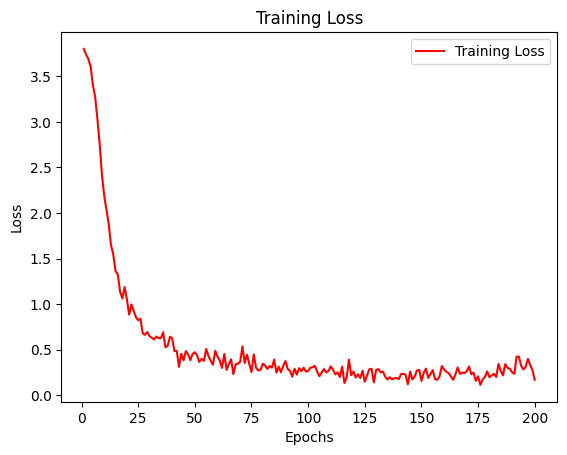

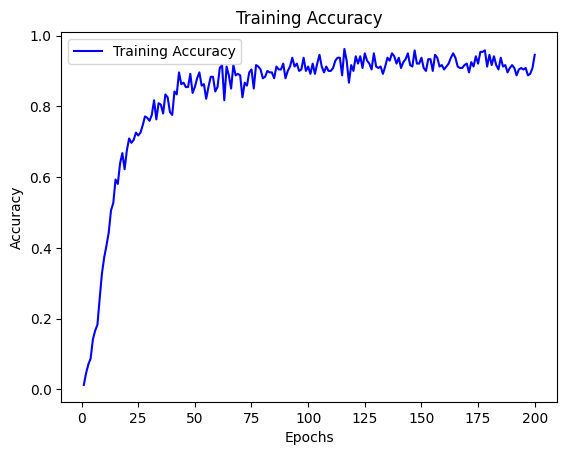

In [195]:
# Retrieve loss and accuracy data from history
loss = history.history['loss']
accuracy = history.history['accuracy']

# Taking the number of epochs
epochs = range(1, len(loss) + 1)

# Plot loss
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


**Save Model**

In [196]:
#savedmodel
model.save('chatbot_model.h5', history)

**Load Sources**

In [197]:
# Load intents data
intents = chatbot_json

# Load words and classes
words = pickle.load(open('data_words.pkl', 'rb'))
classes = pickle.load(open('data_classes.pkl', 'rb'))

# Load model
model = load_model('chatbot_model.h5')

**Testing Preparation**

In [198]:
#cleaning input sentences
def clean_sentence(sentence):
    words_in_sentence = nltk.word_tokenize(sentence) #Tokenization: words to array
    words_in_sentence = [lemmatizer.lemmatize(word.lower()) for word in words_in_sentence] #Lemmatization: turns words into base forms
    return words_in_sentence

In [199]:
#bag of words from sentence
def bow(sentence, words, show_details=True):
    words_in_sentence = clean_sentence(sentence) # Clean sentence input
    bag = [0]*len(words) #create list bag that will be used as the bag-of-words vector representation.
    for word in words_in_sentence:
        for i, word in enumerate(words):
            bag[i] = 1 if word == sentence else bag[i] #indicates that the word is in the input sentence
            if show_details:
                print("found in bag: %s" % word)
                
    #Returns a bag-of-words vector representation in the form of a numpy array.
    return(np.array(bag)) 

In [200]:
#Intent class prediction based on input sentences using the trained model
def predict_classes(sentence, model):

    # converts input sentences into bag of words vectors as input for the model.
    prediction = bow(sentence, words,show_details=False)
    #Using the model to make predictions on bag-of-words vectors
    result = model.predict(np.array([prediction]))[0] 

    #Filter the prediction results based on the error threshold.
    error_threshold = 0.25
    results = [[i,r] for i,r in enumerate(result) if r>error_threshold]
    
    results.sort(key=lambda x: x[1], reverse=True) #Sort the prediction results based on probability strength (in descending order).
    return_list = [] #Intents (classes)
    for r in results:
        return_list.append({"intent": classes[r[0]], #retrieves the class (intent) from the class index stored in results 
                            "probability": str(r[1]) #converts probabilities to strings before saving
                            }
                           )
    return return_list

In [201]:
#Get the appropriate response based on the intent predicted by the model.
def getResponse(ints, intents_json):
    tag = ints[0]['intent']
    list_of_intents = intents_json
    for i in list_of_intents:
        if i["tag"] == tag: #Checks current tag intent matches the predicted tag.
            result = random.choice(i['responses'])
            break
    return result


In [202]:
#Get chatbot response based on model
def chatbot_response(text):
    ints = predict_classes(text, model)
    response = getResponse(ints, intents)
    return response

In [76]:
'''
# Chatbot Greeting
greetings_inputs = ('hai', 'hello', 'hey','whats up', 'ingin bertanya')
greetings_responses = ('Hai, kamu punya pertanyaan apa?', 'Hallo, Ada yang bisa CarupAI bantu?', 'Sampah apa yang mau kamu tanyakan?')
def greetings(sentence):
    for word in sentence.split():
        if word.lower() in greetings_inputs:
            return random.choice(greetings_responses)
    return None
'''

"\n# Chatbot Greeting\ngreetings_inputs = ('hai', 'hello', 'hey','whats up', 'ingin bertanya')\ngreetings_responses = ('Hai, kamu punya pertanyaan apa?', 'Hallo, Ada yang bisa CarupAI bantu?', 'Sampah apa yang mau kamu tanyakan?')\ndef greetings(sentence):\n    for word in sentence.split():\n        if word.lower() in greetings_inputs:\n            return random.choice(greetings_responses)\n    return None\n"

In [205]:
# Decode the byte content to string
chatbot_json_str = chatbot_json.decode('utf-8')

# Load the JSON data
chatbot_json = json.loads(chatbot_json_str)

AttributeError: ignored

**TESTING**

In [206]:
#Chatbot Flow
flag = True
print('Hai, Aku CarupAI. Aku akan membantu kamu menjawab pertanyaan tentang sampah. Boleh langsung tanya aja ya')

while flag:
    newMessage = input("")
    
    if newMessage.lower() == "end":
        flag = False
        print('CarupAI: Sampai jumpa, jangan lupa kelola sampah kamu ya!')
    else:
        intents = predict_classes(newMessage, model)
        res = getResponse(intents, chatbot_json['intents'])
        print(res)


Hai, Aku CarupAI. Aku akan membantu kamu menjawab pertanyaan tentang sampah. Boleh langsung tanya aja ya
hai
1/1 [==============================] - 0s 63ms/step
Ada yang bisa CarupAI bantu?
sampah
1/1 [==============================] - 0s 21ms/step
Sampah adalah segala jenis material atau zat yang dihasilkan oleh manusia atau alam yang dianggap tidak berguna, tidak diinginkan, atau tidak diperlukan lagi. Sampah bisa berupa sisa-sisa makanan, kertas, plastik, logam, kaca, kain, limbah organik, dan bahan-bahan lainnya. Sampah juga dapat mencakup material yang dapat merusak lingkungan seperti baterai, bahan kimia berbahaya, atau limbah medis.
kardus
1/1 [==============================] - 0s 21ms/step
Kardus adalah bahan kemasan yang terbuat dari kertas tebal yang diperkuat dengan lapisan karton atau lembaran tebal lainnya. Kardus sering digunakan untuk membuat kotak atau wadah yang kuat dan tahan lama untuk mengemas dan melindungi barang-barang selama transportasi dan penyimpanan.
Sampah 